<a href="https://colab.research.google.com/github/jon-chun/sentimentarcs/blob/main/sa_CNN_GLoVE_IMDB_20210914.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN with GLoVE Embeddings on IMDB**

* https://github.com/bentrevett/pytorch-sentiment-analysis

# 4 - Convolutional Sentiment Analysis

In the previous notebooks, we managed to achieve a test accuracy of ~85% using RNNs and an implementation of the [Bag of Tricks for Efficient Text Classification](https://arxiv.org/abs/1607.01759) model. In this notebook, we will be using a *convolutional neural network* (CNN) to conduct sentiment analysis, implementing the model from [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882).

**Note**: This tutorial is not aiming to give a comprehensive introduction and explanation of CNNs. For a better and more in-depth explanation check out [here](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/) and [here](https://cs231n.github.io/convolutional-networks/).

Traditionally, CNNs are used to analyse images and are made up of one or more *convolutional* layers, followed by one or more linear layers. The convolutional layers use filters (also called *kernels* or *receptive fields*) which scan across an image and produce a processed version of the image. This processed version of the image can be fed into another convolutional layer or a linear layer. Each filter has a shape, e.g. a 3x3 filter covers a 3 pixel wide and 3 pixel high area of the image, and each element of the filter has a weight associated with it, the 3x3 filter would have 9 weights. In traditional image processing these weights were specified by hand by engineers, however the main advantage of the convolutional layers in neural networks is that these weights are learned via backpropagation. 

The intuitive idea behind learning the weights is that your convolutional layers act like *feature extractors*, extracting parts of the image that are most important for your CNN's goal, e.g. if using a CNN to detect faces in an image, the CNN may be looking for features such as the existance of a nose, mouth or a pair of eyes in the image.

So why use CNNs on text? In the same way that a 3x3 filter can look over a patch of an image, a 1x2 filter can look over a 2 sequential words in a piece of text, i.e. a bi-gram. In the previous tutorial we looked at the FastText model which used bi-grams by explicitly adding them to the end of a text, in this CNN model we will instead use multiple filters of different sizes which will look at the bi-grams (a 1x2 filter), tri-grams (a 1x3 filter) and/or n-grams (a 1x$n$ filter) within the text.

The intuition here is that the appearance of certain bi-grams, tri-grams and n-grams within the review will be a good indication of the final sentiment.

## Preparing Data

As in the previous notebooks, we'll prepare the data. 

Unlike the previous notebook with the FastText model, we no longer explicitly need to create the bi-grams and append them to the end of the sentence.

As convolutional layers expect the batch dimension to be first we can tell TorchText to return the data already permuted using the `batch_first = True` argument on the field.

In [ ]:
%%time

import torch
from torchtext.legacy import data
from torchtext.legacy import datasets
import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', 
                  tokenizer_language = 'en_core_web_sm',
                  batch_first = True)
LABEL = data.LabelField(dtype = torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:00<00:00, 95.0MB/s]


Build the vocab and load the pre-trained word embeddings.

In [ ]:
%%time

MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:41, 5.34MB/s]                           
100%|█████████▉| 399999/400000 [00:15<00:00, 25899.33it/s]


As before, we create the iterators.

In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

## Build the Model

Now to build our model.

The first major hurdle is visualizing how CNNs are used for text. Images are typically 2 dimensional (we'll ignore the fact that there is a third "colour" dimension for now) whereas text is 1 dimensional. However, we know that the first step in almost all of our previous tutorials (and pretty much all NLP pipelines) is converting the words into word embeddings. This is how we can visualize our words in 2 dimensions, each word along one axis and the elements of vectors aross the other dimension. Consider the 2 dimensional representation of the embedded sentence below:

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment9.png?raw=1)

We can then use a filter that is **[n x emb_dim]**. This will cover $n$ sequential words entirely, as their width will be `emb_dim` dimensions. Consider the image below, with our word vectors are represented in green. Here we have 4 words with 5 dimensional embeddings, creating a [4x5] "image" tensor. A filter that covers two words at a time (i.e. bi-grams) will be **[2x5]** filter, shown in yellow, and each element of the filter with have a _weight_ associated with it. The output of this filter (shown in red) will be a single real number that is the weighted sum of all elements covered by the filter.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment12.png?raw=1)

The filter then moves "down" the image (or across the sentence) to cover the next bi-gram and another output (weighted sum) is calculated. 

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment13.png?raw=1)

Finally, the filter moves down again and the final output for this filter is calculated.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment14.png?raw=1)

In our case (and in the general case where the width of the filter equals the width of the "image"), our output will be a vector with number of elements equal to the height of the image (or lenth of the word) minus the height of the filter plus one, $4-2+1=3$ in this case.

This example showed how to calculate the output of one filter. Our model (and pretty much all CNNs) will have lots of these filters. The idea is that each filter will learn a different feature to extract. In the above example, we are hoping each of the **[2 x emb_dim]** filters will be looking for the occurence of different bi-grams. 

In our model, we will also have different sizes of filters, heights of 3, 4 and 5, with 100 of each of them. The intuition is that we will be looking for the occurence of different tri-grams, 4-grams and 5-grams that are relevant for analysing sentiment of movie reviews.

The next step in our model is to use *pooling* (specifically *max pooling*) on the output of the convolutional layers. This is similar to the FastText model where we performed the average over each of the word vectors, implemented by the `F.avg_pool2d` function, however instead of taking the average over a dimension, we are taking the maximum value over a dimension. Below an example of taking the maximum value (0.9) from the output of the convolutional layer on the example sentence (not shown is the activation function applied to the output of the convolutions).

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment15.png?raw=1)

The idea here is that the maximum value is the "most important" feature for determining the sentiment of the review, which corresponds to the "most important" n-gram within the review. How do we know what the "most important" n-gram is? Luckily, we don't have to! Through backpropagation, the weights of the filters are changed so that whenever certain n-grams that are highly indicative of the sentiment are seen, the output of the filter is a "high" value. This "high" value then passes through the max pooling layer if it is the maximum value in the output. 

As our model has 100 filters of 3 different sizes, that means we have 300 different n-grams the model thinks are important. We concatenate these together into a single vector and pass them through a linear layer to predict the sentiment. We can think of the weights of this linear layer as "weighting up the evidence" from each of the 300 n-grams and making a final decision. 

### Implementation Details

We implement the convolutional layers with `nn.Conv2d`. The `in_channels` argument is the number of "channels" in your image going into the convolutional layer. In actual images this is usually 3 (one channel for each of the red, blue and green channels), however when using text we only have a single channel, the text itself. The `out_channels` is the number of filters and the `kernel_size` is the size of the filters. Each of our `kernel_size`s is going to be **[n x emb_dim]** where $n$ is the size of the n-grams.

In PyTorch, RNNs want the input with the batch dimension second, whereas CNNs want the batch dimension first - we do not have to permute the data here as we have already set `batch_first = True` in our `TEXT` field. We then pass the sentence through an embedding layer to get our embeddings. The second dimension of the input into a `nn.Conv2d` layer must be the channel dimension. As text technically does not have a channel dimension, we `unsqueeze` our tensor to create one. This matches with our `in_channels=1` in the initialization of our convolutional layers. 

We then pass the tensors through the convolutional and pooling layers, using the `ReLU` activation function after the convolutional layers. Another nice feature of the pooling layers is that they handle sentences of different lengths. The size of the output of the convolutional layer is dependent on the size of the input to it, and different batches contain sentences of different lengths. Without the max pooling layer the input to our linear layer would depend on the size of the input sentence (not what we want). One option to rectify this would be to trim/pad all sentences to the same length, however with the max pooling layer we always know the input to the linear layer will be the total number of filters. **Note**: there an exception to this if your sentence(s) are shorter than the largest filter used. You will then have to pad your sentences to the length of the largest filter. In the IMDb data there are no reviews only 5 words long so we don't have to worry about that, but you will if you are using your own data.

Finally, we perform dropout on the concatenated filter outputs and then pass them through a linear layer to make our predictions.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.conv_0 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[0], embedding_dim))
        
        self.conv_1 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[1], embedding_dim))
        
        self.conv_2 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[2], embedding_dim))
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

Currently the `CNN` model can only use 3 different sized filters, but we can actually improve the code of our model to make it more generic and take any number of filters.

We do this by placing all of our convolutional layers in a  `nn.ModuleList`, a function used to hold a list of PyTorch `nn.Module`s. If we simply used a standard Python list, the modules within the list cannot be "seen" by any modules outside the list which will cause us some errors.

We can now pass an arbitrary sized list of filter sizes and the list comprehension will create a convolutional layer for each of them. Then, in the `forward` method we iterate through the list applying each convolutional layer to get a list of convolutional outputs, which we also feed through the max pooling in a list comprehension before concatenating together and passing through the dropout and linear layers.

In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

We can also implement the above model using 1-dimensional convolutional layers, where the embedding dimension is the "depth" of the filter and the number of tokens in the sentence is the width.

We'll run our tests in this notebook using the 2-dimensional convolutional model, but leave the implementation for the 1-dimensional model below for anyone interested. 

In [ ]:
class CNN1d(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embedding_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.permute(0, 2, 1)
        
        #embedded = [batch size, emb dim, sent len]
        
        conved = [F.relu(conv(embedded)) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

We create an instance of our `CNN` class. 

We can change `CNN` to `CNN1d` if we want to run the 1-dimensional convolutional model, noting that both models give almost identical results.

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

Checking the number of parameters in our model we can see it has about the same as the FastText model. 

Both the `CNN` and the `CNN1d` models have the exact same number of parameters.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,620,801 trainable parameters


Next, we'll load the pre-trained embeddings

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-1.1321, -1.6361,  1.2328,  ...,  0.5073,  0.5468, -1.2139],
        [-0.1709,  0.3923, -0.1879,  ...,  0.9795,  0.5425,  1.5589],
        [ 0.4197,  0.4978, -0.2824,  ...,  0.2822,  1.0179, -0.4626]])

Then zero the initial weights of the unknown and padding tokens.

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

## Train the Model

Training is the same as before. We initialize the optimizer, loss function (criterion) and place the model and criterion on the GPU (if available)

In [ ]:
%%time

import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

CPU times: user 2.37 s, sys: 1.2 s, total: 3.57 s
Wall time: 6.54 s


We implement the function to calculate accuracy...

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

We define a function for training our model...

**Note**: as we are using dropout again, we must remember to use `model.train()` to ensure the dropout is "turned on" while training.

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

We define a function for testing our model...

**Note**: again, as we are now using dropout, we must remember to use `model.eval()` to ensure the dropout is "turned off" while evaluating.

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Let's define our function to tell us how long epochs take.

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model...

In [ ]:
%%time

N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 01 | Epoch Time: 0m 19s
	Train Loss: 0.647 | Train Acc: 61.52%
	 Val. Loss: 0.495 |  Val. Acc: 77.85%
Epoch: 02 | Epoch Time: 0m 19s
	Train Loss: 0.425 | Train Acc: 80.75%
	 Val. Loss: 0.371 |  Val. Acc: 83.35%
Epoch: 03 | Epoch Time: 0m 19s
	Train Loss: 0.301 | Train Acc: 87.58%
	 Val. Loss: 0.333 |  Val. Acc: 85.81%
Epoch: 04 | Epoch Time: 0m 19s
	Train Loss: 0.227 | Train Acc: 90.88%
	 Val. Loss: 0.326 |  Val. Acc: 86.67%
Epoch: 05 | Epoch Time: 0m 20s
	Train Loss: 0.161 | Train Acc: 94.15%
	 Val. Loss: 0.345 |  Val. Acc: 86.66%
CPU times: user 1min 38s, sys: 312 ms, total: 1min 38s
Wall time: 1min 39s


We get test results comparable to the previous 2 models!

In [ ]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.343 | Test Acc: 85.31%


## User Input

And again, as a sanity check we can check some input sentences

**Note**: As mentioned in the implementation details, the input sentence has to be at least as long as the largest filter height used. We modify our `predict_sentiment` function to also accept a minimum length argument. If the tokenized input sentence is less than `min_len` tokens, we append padding tokens (`<pad>`) to make it `min_len` tokens.

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_sentiment(model, sentence, min_len = 5):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

An example negative review...

In [ ]:
predict_sentiment(model, "This film is terrible")

0.06784069538116455

An example positive review...

In [ ]:
predict_sentiment(model, "This film is great")

0.9278099536895752

In [ ]:
import pandas as pd

corpus_sents_df = pd.read_csv('sum_4andDNN_emforster_howardsend.csv')
corpus_sents_df.head()

,Unnamed: 0,sent_no,parag_no,sect_no,sent_raw,sent_clean,char_len,token_len,sentimentr,sentimentr_stdscaler,sentimentr_medianiqr,sentimentr_lnorm_stdscaler,sentimentr_lnorm_medianiqr,syuzhet,syuzhet_stdscaler,syuzhet_medianiqr,syuzhet_lnorm_stdscaler,syuzhet_lnorm_medianiqr,bing,bing_stdscaler,bing_medianiqr,bing_lnorm_stdscaler,bing_lnorm_medianiqr,sentiword,sentiword_stdscaler,sentiword_medianiqr,sentiword_lnorm_stdscaler,sentiword_lnorm_medianiqr,senticnet,senticnet_stdscaler,senticnet_medianiqr,senticnet_lnorm_stdscaler,senticnet_lnorm_medianiqr,nrc,nrc_stdscaler,nrc_medianiqr,nrc_lnorm_stdscaler,nrc_lnorm_medianiqr,afinn,afinn_stdscaler,...,vader,vader_stdscaler,vader_medianiqr,vader_lnorm_stdscaler,vader_lnorm_medianiqr,textblob,textblob_stdscaler,textblob_medianiqr,textblob_lnorm_stdscaler,textblob_lnorm_medianiqr,pattern,pattern_stdscaler,pattern_medianiqr,pattern_lnorm_stdscaler,pattern_lnorm_medianiqr,stanza,stanza_stdscaler,stanza_medianiqr,stanza_lnorm_stdscaler,stanza_lnorm_medianiqr,flair,flair_stdscaler,flair_medianiqr,flair_lnorm_stdscaler,flair_lnorm_medianiqr,sentimentr_stdscaler_roll10,syuzhet_stdscaler_roll10,bing_stdscaler_roll10,sentiword_stdscaler_roll10,senticnet_stdscaler_roll10,nrc_stdscaler_roll10,afinn_stdscaler_roll10,vader_stdscaler_roll10,textblob_stdscaler_roll10,flair_stdscaler_roll10,pattern_stdscaler_roll10,stanza_stdscaler_roll10,multinb,fcn,lstm
0,0,0,0,0,One may as well begin with Helen s letters to ...,one may as well begin with helen s letters to ...,57,12,0.8,0.860366,1.066667,0.860366,1.182609,0.8,0.869977,1.230769,0.869977,1.356164,28.695173,1.068757,28.695173,1.068757,2.391264,0.3556,0.599617,0.669365,0.599617,0.587268,-0.198,-0.507598,-0.343480,-0.507598,-0.335770,0.0,-0.186657,0.0,-0.186657,0.0,0.0,-0.046083,...,0.2732,0.625733,0.922973,0.625733,1.250000,0.0,-0.160811,0.0,-0.160811,0.000000,0.0,-0.006626,0.000000,-0.006626,0.000000,5.029195,0.089074,0.342867,0.089074,-0.065170,0.8856,1.083008,0.814054,1.083008,0.567417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.607075,0.649300
1,1,1,1,0,"Howards End,",howards end,12,2,0.0,-0.126851,0.000000,-0.126851,0.000000,0.0,-0.152176,0.000000,-0.152176,0.000000,0.000000,0.024963,0.000000,0.024963,0.000000,0.0000,-0.084324,0.000000,-0.084324,0.000000,0.061,-0.267975,-0.108133,-0.267975,0.096591,0.0,-0.186657,0.0,-0.186657,0.0,0.0,-0.046083,...,0.0000,-0.139319,0.000000,-0.139319,0.000000,0.0,-0.160811,0.0,-0.160811,0.000000,0.0,-0.006626,0.000000,-0.006626,0.000000,2.521600,-0.917810,-0.612756,-0.917810,3.889256,0.5713,0.739689,0.652609,0.739689,1.678001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.555926,0.459584
2,2,2,2,0,Tuesday.,tuesday,8,1,0.0,-0.126851,0.000000,-0.126851,0.000000,0.0,-0.152176,0.000000,-0.152176,0.000000,0.000000,0.024963,0.000000,0.024963,0.000000,0.0000,-0.084324,0.000000,-0.084324,0.000000,0.000,-0.324412,-0.163562,-0.324412,-0.183983,0.0,-0.186657,0.0,-0.186657,0.0,0.0,-0.046083,...,0.0000,-0.139319,0.000000,-0.139319,0.000000,0.0,-0.160811,0.0,-0.160811,0.000000,0.0,-0.006626,0.000000,-0.006626,0.000000,10.000000,2.085020,2.237199,2.085020,44.947236,0.6004,0.771475,0.667557,0.771475,3.328020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.579073,0.502600
3,3,3,3,0,"Dearest Meg,",dearest meg,12,2,0.0,-0.126851,0.000000,-0.126851,0.000000,0.0,-0.152176,0.000000,-0.152176,0.000000,0.000000,0.024963,0.000000,0.024963,0.000000,0.0000,-0.084324,0.000000,-0.084324,0.000000,0.000,-0.324412,-0.163562,-0.324412,-0.183983,0.0,-0.186657,0.0,-0.186657,0.0,0.0,-0.046083,...,0.5574,1.421588,1.883108,1.421588,15.301977,0.0,-0.160811,0.0,-0.160811,0.000000,0.0,-0.006626,0.000000,-0.006626,0.000000,2.521600,-0.917810,-0.612756,-0.917810,3.889256,0.9817,1.187981,0.863417,1.187981,2.753724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.579073,0.488088
4,4,4,4,0,It isn t going to be what we expected.,it isn t going to be what we expected,38,9,0.0,-0.126851,0.000000,-0.126851,0.000000,0.0,-0.152176,0.0000

In [ ]:
%%time

corpus_sents_df['cnn_glove'] = corpus_sents_df['sent_clean'].apply(lambda x: predict_sentiment(model, x))

CPU times: user 6.2 s, sys: 16.9 ms, total: 6.22 s
Wall time: 6.21 s


In [ ]:
corpus_sents_df.to_csv('sum_4andCNN_emforster_howardsend.csv')

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 100
plt.rc('figure', facecolor='white')

In [ ]:
CORPUS_FULL = "Howards End by EM Forster"

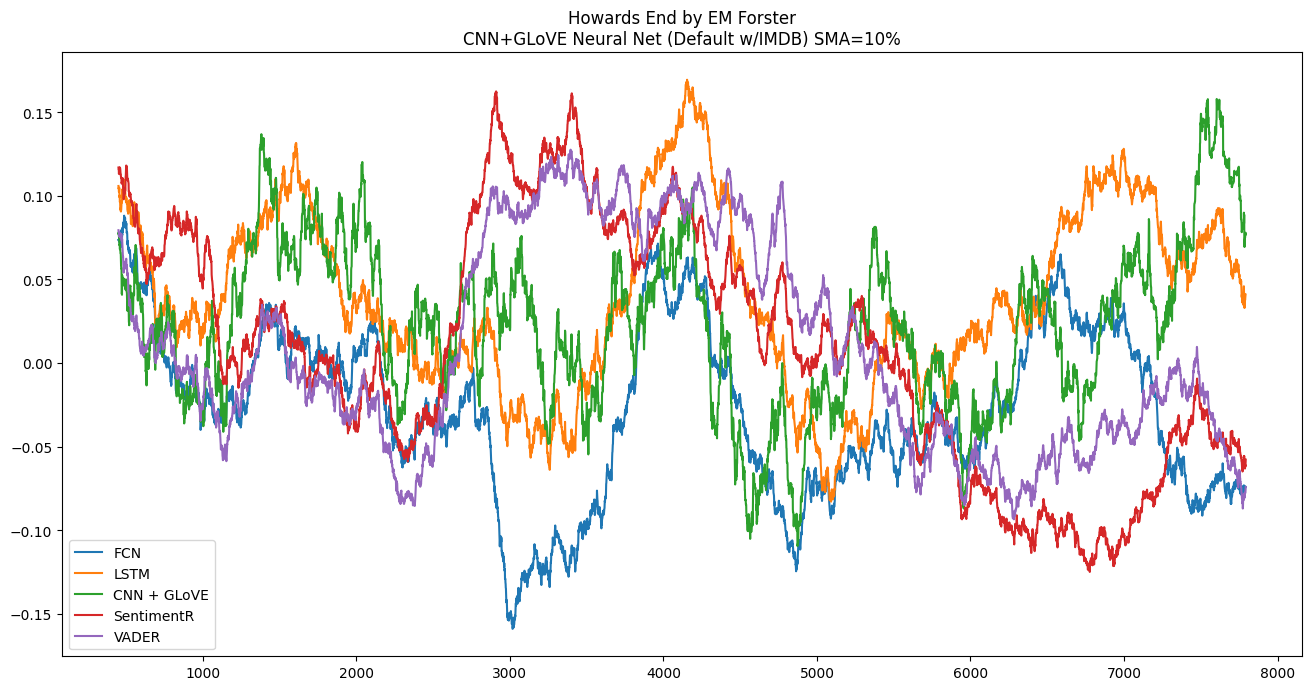

In [ ]:
corpus_sents_df['fcn'].apply(lambda x: 8*(x-0.55)).rolling(900, center=True).mean().plot(label='FCN')
corpus_sents_df['lstm'].apply(lambda x: 5*(x-0.47)).rolling(900, center=True).mean().plot(label='LSTM')
corpus_sents_df['cnn_glove'].apply(lambda x: 22*(x-0.505)).rolling(900, center=True).mean().plot(label='CNN + GLoVE')
corpus_sents_df['sentimentr_stdscaler'].rolling(900, center=True).mean().plot(label='SentimentR')
corpus_sents_df['vader_stdscaler'].rolling(900, center=True).mean().plot(label='VADER')
plt.legend(loc='best');
plt.title(f'{CORPUS_FULL}\nCNN+GLoVE Neural Net (Default w/IMDB) SMA=10%');